In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
#df = pd.read_csv('Data/loan.csv')

df=pd.read_csv('../input/projectdata/loan.csv')

In [4]:


df.info(verbose=True, null_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 111 columns):
 #    Column                          Non-Null Count  Dtype  
---   ------                          --------------  -----  
 0    id                              39717 non-null  int64  
 1    member_id                       39717 non-null  int64  
 2    loan_amnt                       39717 non-null  int64  
 3    funded_amnt                     39717 non-null  int64  
 4    funded_amnt_inv                 39717 non-null  float64
 5    term                            39717 non-null  object 
 6    int_rate                        39717 non-null  object 
 7    installment                     39717 non-null  float64
 8    grade                           39717 non-null  object 
 9    sub_grade                       39717 non-null  object 
 10   emp_title                       37258 non-null  object 
 11   emp_length                      38642 non-null  object 
 12   home_ownership  

In [5]:
df.shape

(39717, 111)

In [6]:
# Remove all null columns
df.dropna(axis=1, how='all', inplace=True)
df.shape

(39717, 57)

In [7]:
# Remove columns having only one unique value. This method assumes standard deviation is zero
df.drop(df.std()[(df.std() == 0)].index, axis=1, inplace=True)
df.shape

(39717, 51)

In [8]:
# Remove next_pymnt_d, id, member_id, url, desc
df.drop(['next_pymnt_d','id','member_id', 'url', 'desc'], axis=1, inplace=True)

In [9]:
# Clean the percentage columns int_rate and revol_util
def clean_percentages(i):
    i = i.str.replace('%', '')
    i = i.astype('float64')
    return i

In [10]:
df['int_rate'] = clean_percentages(df['int_rate'])
df['revol_util'] = clean_percentages(df['revol_util'])

In [11]:
# Use the average to fill the nan values
df['revol_util'] = df['revol_util'].fillna(df['revol_util'].mean())
# should we use mode instead?

In [12]:
# Replace nan values with mode
df['pub_rec_bankruptcies'].value_counts(dropna=False)

0.0    37339
1.0     1674
NaN      697
2.0        7
Name: pub_rec_bankruptcies, dtype: int64

In [13]:
df.groupby('pub_rec_bankruptcies', dropna=False).mean()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,...,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt
pub_rec_bankruptcies,,,,,,,,,,,,,,,,,,,,,
0.0,11301.622298,11027.154584,10606.266580,11.980606,326.132241,69186.729521,13.351199,0.145264,0.862851,36.963931,...,53.126521,52.904260,12274.237895,11818.645558,9896.948891,2280.254760,1.333720,95.700599,12.372995,2719.846671
1.0,9905.704898,9634.886499,9080.053971,13.484570,290.273202,63837.143590,13.543076,0.153524,0.953405,39.553655,...,26.331511,25.648722,10285.177721,9709.972987,7991.858638,2211.749194,1.131934,80.438190,8.659830,2237.085974
2.0,12800.000000,12453.571429,12303.834876,15.971429,373.270000,77100.000000,13.010000,0.142857,0.428571,39.000000,...,978.267143,976.072857,14281.326910,13919.484286,9482.658571,4777.605714,2.142857,18.918571,0.189186,485.282857
NaN,9956.420373,9829.878049,2355.741259,10.640230,322.301119,69544.443271,10.838465,0.196557,1.011478,12.955137,...,0.000000,0.000000,10156.769530,2531.024175,8573.185352,1474.270230,3.479541,105.834471,23.300418,1564.282554


In [14]:
df['pub_rec_bankruptcies'].fillna(df['pub_rec_bankruptcies'].mode()[0], inplace=True)

In [15]:
# We'll consider 0-1 as 0 years, 10+ as 10 years
df['emp_length'].value_counts(dropna=False)

10+ years    8879
< 1 year     4583
2 years      4388
3 years      4095
4 years      3436
5 years      3282
1 year       3240
6 years      2229
7 years      1773
8 years      1479
9 years      1258
NaN          1075
Name: emp_length, dtype: int64

In [16]:
# Function to clean emp_length
def clean_emp(i):
    i = i.str.replace('< 1 year','0')
    i = i.fillna('0')
    i = i.str.replace(' ','')
    i = i.str.replace('years','')
    i = i.str.replace('year','')
    i = i.str.replace('+','')
    i = i.astype('int64')
    return i

In [17]:
df['emp_length'] = clean_emp(df['emp_length'])

In [18]:
df['emp_length'].value_counts()

10    8879
0     5658
2     4388
3     4095
4     3436
5     3282
1     3240
6     2229
7     1773
8     1479
9     1258
Name: emp_length, dtype: int64

In [19]:
# Remove this column as most of the values are missing
df['mths_since_last_delinq'].value_counts(dropna=False)

NaN      25682
0.0        443
15.0       252
30.0       247
23.0       247
         ...  
89.0         1
107.0        1
85.0         1
97.0         1
95.0         1
Name: mths_since_last_delinq, Length: 96, dtype: int64

In [20]:
df.drop('mths_since_last_delinq', axis=1, inplace=True)

In [21]:
# Change nan values to other
df['emp_title'].value_counts(dropna=False)

NaN                                2459
US Army                             134
Bank of America                     109
IBM                                  66
AT&T                                 59
                                   ... 
AMEC                                  1
lee county sheriff                    1
Bacon County Board of Education       1
Hotpads                               1
Evergreen Center                      1
Name: emp_title, Length: 28821, dtype: int64

In [22]:
df['emp_title'].fillna('Other', inplace=True)

In [23]:
# Change the 11 nan values to the mode of the column
df['title'].value_counts()

Debt Consolidation                  2184
Debt Consolidation Loan             1729
Personal Loan                        659
Consolidation                        517
debt consolidation                   505
                                    ... 
your rate is better than my rate       1
Concession Trailer                     1
gregs                                  1
EZover                                 1
JAL Loan                               1
Name: title, Length: 19615, dtype: int64

In [24]:
df['title'].fillna(df['title'].mode()[0], inplace=True)

In [25]:
# Remove ' months' and convert into year
df['term'].value_counts()

 36 months    29096
 60 months    10621
Name: term, dtype: int64

In [26]:
# Function to clean the term column
def clean_term(i):
    i = i.str.replace(' months','').astype('int64')
    i = i/12
    i = i.astype('int64')
    return i

In [27]:
df['term'] = clean_term(df['term'])

In [28]:
# Remove mths_since_last_record since most of the values are missing
df.drop('mths_since_last_record', axis=1, inplace=True)

In [29]:
# Function to clean date objects
def clean_date(i):
    i = i.str.replace('-', ' ')
    i = i.str[:4]+'20'+i.str[4:]
    i = pd.to_datetime(i).dt.to_period('M')
    return(i)

In [30]:
# Change issue_d to datetime
df['issue_d'] = clean_date(df['issue_d'])

In [31]:
df['last_credit_pull_d'] = clean_date(df['last_credit_pull_d'])

In [32]:
df[df['last_credit_pull_d'].isna()]

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,application_type,pub_rec_bankruptcies
26025,5000,5000,5000.0,3,11.12,163.98,B,B3,Other,5,...,2553.55,702.45,0.0,106.96,1.34,Jun-12,163.98,NaT,INDIVIDUAL,0.0
39476,1000,1000,875.0,3,7.12,30.94,A,A1,Other,0,...,1000.00,110.81,0.0,0.00,0.00,Aug-10,185.80,NaT,INDIVIDUAL,0.0


In [33]:
df['last_credit_pull_d'].fillna(df['issue_d']+df['term'], inplace=True)

In [34]:
df['last_pymnt_d'] = clean_date(df['last_pymnt_d'])

In [35]:
df['last_pymnt_d']

0        2015-01
1        2013-04
2        2014-06
3        2015-01
4        2016-05
          ...   
39712    2010-07
39713    2010-07
39714    2008-04
39715    2008-01
39716    2010-06
Name: last_pymnt_d, Length: 39717, dtype: period[M]

In [36]:
df[df['last_pymnt_d'].isna()]

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,application_type,pub_rec_bankruptcies
26,15000,15000,8725.0,3,14.27,514.64,C,C2,nyc transit,9,...,0.0,0.0,0.0,0.00,0.0000,NaT,0.0,2016-05,INDIVIDUAL,0.0
2724,8000,8000,3975.0,3,14.65,275.96,C,C3,Southern Felt,10,...,0.0,0.0,0.0,0.00,0.0000,NaT,0.0,2016-05,INDIVIDUAL,0.0
3613,6400,6400,6400.0,5,18.25,163.39,D,D5,akrons children hospitial,5,...,0.0,0.0,0.0,366.75,66.0150,NaT,0.0,2012-04,INDIVIDUAL,0.0
3985,18000,18000,18000.0,5,19.03,467.23,E,E2,ZIMFA INC,4,...,0.0,0.0,0.0,0.00,0.0000,NaT,0.0,2016-04,INDIVIDUAL,0.0
4206,1800,1800,1800.0,3,8.90,57.16,A,A5,Hospira worldwide,9,...,0.0,0.0,0.0,1800.00,0.0000,NaT,0.0,2016-05,INDIVIDUAL,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36185,20000,20000,13975.0,3,11.89,663.28,B,B4,US Army,10,...,0.0,0.0,0.0,4493.30,1381.4454,NaT,0.0,2009-12,INDIVIDUAL,0.0
36206,7800,7800,7725.0,3,10.95,255.17,B,B1,FLACS,0,...,0.0,0.0,0.0,0.00,0.0000,NaT,0.0,2016-05,INDIVIDUAL,0.0
36209,2000,2000,2000.0,3,16.00,70.32,E,E2,Portland State Uniersity Distance Learning Center,0,...,0.0,0.0,0.0,89.99,0.9000,NaT,0.0,2009-12,INDIVIDUAL,0.0
36937,25000,25000,11625.0,3,13.79,851.89,C,C5,ARES Corporation,1,...,0.0,0.0,0.0,0.00,0.0000,NaT,0.0,2009-06,INDIVIDUAL,0.0


In [37]:
(df['issue_d']-df['last_pymnt_d']).value_counts()

<-36 * MonthEnds>    6214
<-37 * MonthEnds>    5589
<-31 * MonthEnds>     778
<-27 * MonthEnds>     754
<-33 * MonthEnds>     752
                     ... 
<-66 * MonthEnds>       1
<-63 * MonthEnds>       1
<-69 * MonthEnds>       1
<-70 * MonthEnds>       1
<-65 * MonthEnds>       1
Length: 69, dtype: int64

In [38]:
df['last_pymnt_d'].fillna(df['issue_d']+df['term'], inplace=True)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 44 columns):
 #   Column                   Non-Null Count  Dtype    
---  ------                   --------------  -----    
 0   loan_amnt                39717 non-null  int64    
 1   funded_amnt              39717 non-null  int64    
 2   funded_amnt_inv          39717 non-null  float64  
 3   term                     39717 non-null  int64    
 4   int_rate                 39717 non-null  float64  
 5   installment              39717 non-null  float64  
 6   grade                    39717 non-null  object   
 7   sub_grade                39717 non-null  object   
 8   emp_title                39717 non-null  object   
 9   emp_length               39717 non-null  int64    
 10  home_ownership           39717 non-null  object   
 11  annual_inc               39717 non-null  float64  
 12  verification_status      39717 non-null  object   
 13  issue_d                  39717 non-null  perio

# Removing Outliers

0    19300
1    10971
2     5812
3     3048
4      326
5      146
6       64
7       35
8       15
Name: inq_last_6mths, dtype: int64

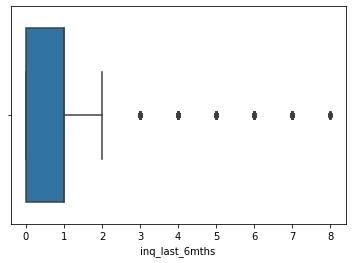

In [40]:
sns.boxplot(df.inq_last_6mths)
df.inq_last_6mths.value_counts()

<AxesSubplot:title={'center':'Without Outliers'}, xlabel='annual_inc'>

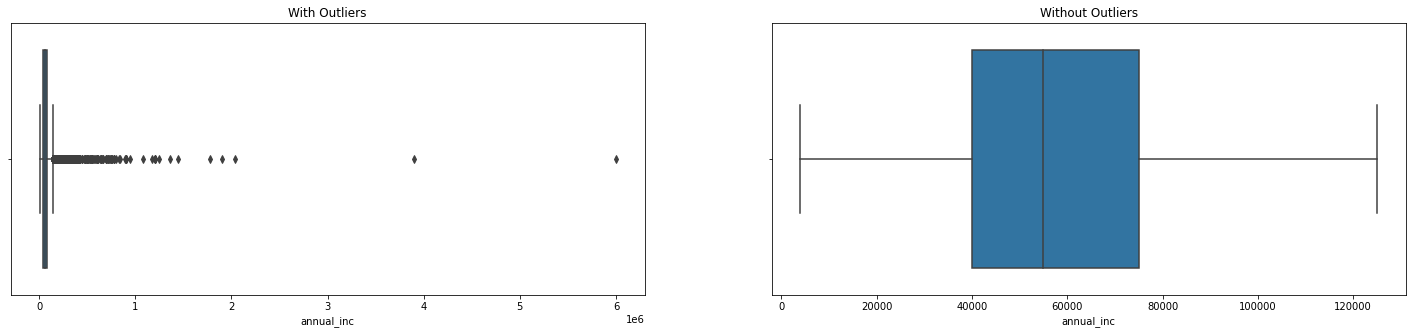

In [41]:
fig,axes=plt.subplots(1,2,figsize=(25,5))
axes[0].set_title('With Outliers')
axes[1].set_title('Without Outliers')
sns.boxplot(df.annual_inc,ax=axes[0])
sns.boxplot(df[df.annual_inc<125000].annual_inc,ax=axes[1])

<AxesSubplot:title={'center':'Without Outliers'}, xlabel='loan_amnt'>

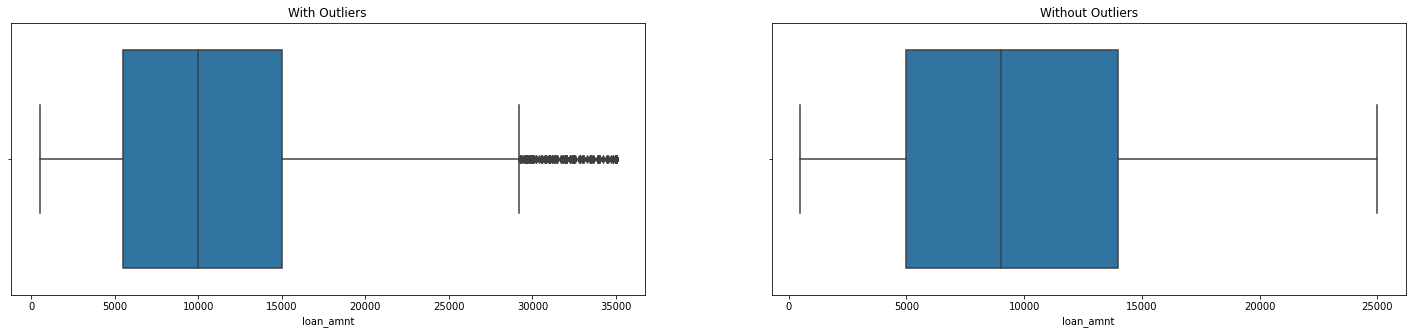

In [42]:
fig,axes=plt.subplots(1,2,figsize=(25,5))
axes[0].set_title('With Outliers')
axes[1].set_title('Without Outliers')
sns.boxplot(df.loan_amnt,ax=axes[0])
sns.boxplot(df[df.loan_amnt<25000].loan_amnt,ax=axes[1])



<AxesSubplot:title={'center':'Without Outliers'}, xlabel='int_rate'>

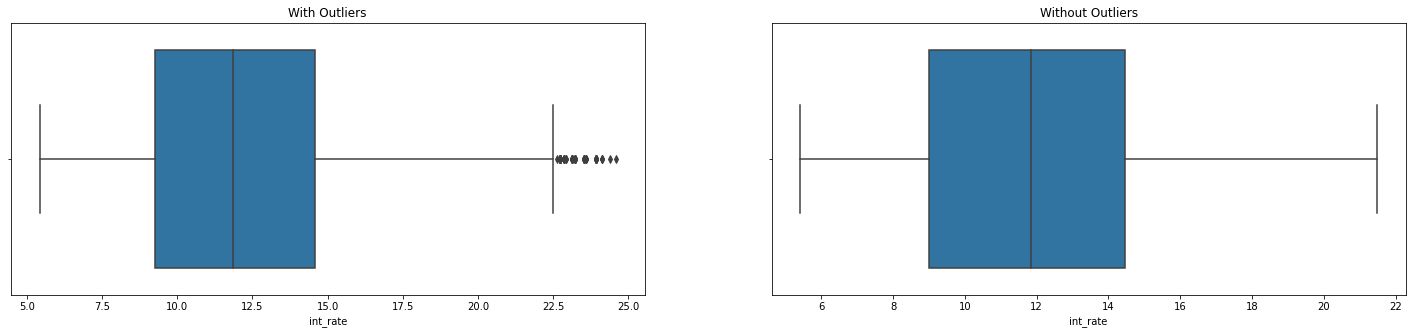

In [43]:
fig,axes=plt.subplots(1,2,figsize=(25,5))
axes[0].set_title('With Outliers')
axes[1].set_title('Without Outliers')
sns.boxplot(df.int_rate,ax=axes[0])
sns.boxplot(df[df.int_rate<21.5].int_rate,ax=axes[1])


<AxesSubplot:title={'center':'Without Outliers'}, xlabel='installment'>

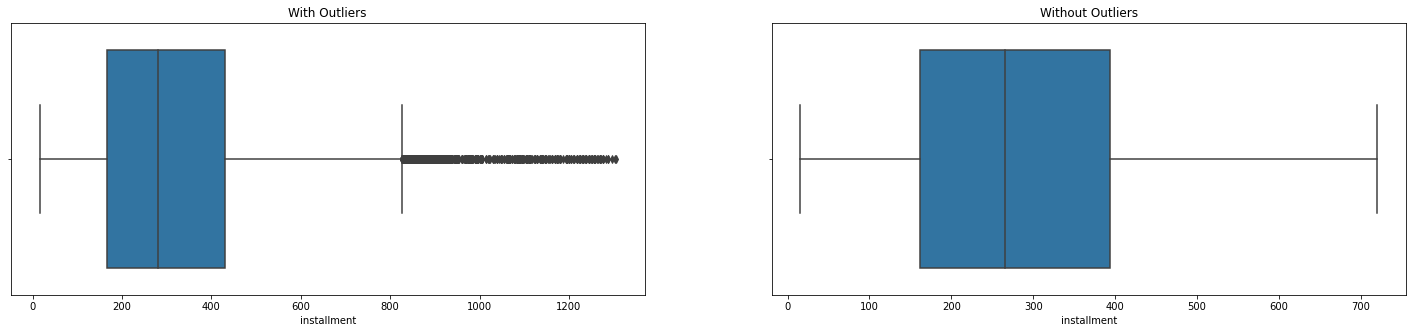

In [44]:
fig,axes=plt.subplots(1,2,figsize=(25,5))
axes[0].set_title('With Outliers')
axes[1].set_title('Without Outliers')
sns.boxplot(df.installment,ax=axes[0])
sns.boxplot(df[df['installment']<720].installment,ax=axes[1])

<AxesSubplot:title={'center':'Without Outliers'}, xlabel='funded_amnt_inv'>

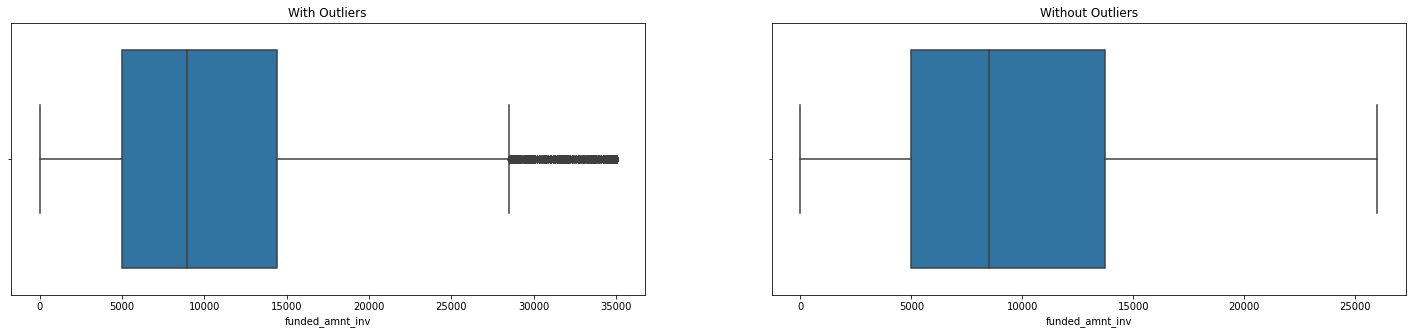

In [45]:
fig,axes=plt.subplots(1,2,figsize=(25,5))
axes[0].set_title('With Outliers')
axes[1].set_title('Without Outliers')
sns.boxplot(df.funded_amnt_inv,ax=axes[0])
sns.boxplot(df[df.funded_amnt_inv<26000].funded_amnt_inv,ax=axes[1])